# Data queries

In [3]:
import pandas
import pandas as pd
from os.path import join
import numpy as np

In [54]:
# Define the main folder and files (hashtags are the files).
src = '/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Data'
hashtags = ('greenwashing') # ['greenwashing'] #, 'greenwashing_correlated_hashtags'] # maybe use brackets instead.

## Collect tweets and compress files

This code below starts queries using singular files, allowing transparency and reproducability for each query. Thanks to [Jana Lasser](https://github.com/JanaLasser) for much of the background and inspiring discussions in another project. 

### Query

In [4]:
# Change file permissions such that execution is allowed
! chmod +x /media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Code/Queries/Greenwashing/greenwashing.sh

# Run the query. Note: this can take a while, depending on the number of Tweets
# that need to be downloaded
! /media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Code/Queries/Greenwashing/greenwashing.sh

In [ ]:
! chmod +x /media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Code/Queries/Greenwashing/greenwashing_no_retweet.sh
! /media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Code/Queries/Greenwashing/greenwashing_no_retweet.sh

In [11]:
! chmod +x /media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Code/Queries/Greenwashing/greenwashing_conversations.sh
! /media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Code/Queries/Greenwashing/greenwashing_conversations.sh

## Create .csv files

Removes duplicate tweets (by ID) but keeps referenced tweets.

In [55]:
! twarc2 csv --extra-input-columns "in_reply_to_user.withheld.scope" /media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Data/Greenwashing/user.jsonl /media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Data/Greenwashing/user.csv

100%|██████████████████████████████████████| 40.5M/40.5M [00:07<00:00, 5.88MB/s]

ℹ️
Read 24921 tweets from 140 lines. 
11506 were referenced tweets, 757 were duplicates.
Wrote 24164 rows and output 93 of 93 input columns in the CSV.



## Extract Tweet IDs

These tweet IDs will be important to share the final results of the project, because Twitter restricts what kind of data may be shared. Actual tweets and account names cannot be shared, but tweet IDs can be included to allow other researchers to reproduce the data set.

In [3]:
def get_Tweet_IDs(src, filename, chunks=False, chunksize=100000):
    data = pd.read_csv(join(src, '{}.csv'.format(filename)), low_memory=False)
    TweetIDs = data['id'].dropna().astype(int).unique()
    print('{}: There are {} Tweets'\
              .format(filename, len(TweetIDs)))
    
    dst = join(src, 'tweet_IDs')
    
    if chunks:
        N_chunks = len(TweetIDs) // chunksize
        print(N_chunks)
        for i in range(N_chunks):
            ID_chunk = TweetIDs[i * chunksize : (i + 1) * chunksize]
            np.savetxt(join(dst, '{}_TweetIDs_{}_to_{}.txt'\
                .format(filename, i * chunksize, (i + 1) * chunksize)),
                ID_chunk, fmt='%d')
        np.savetxt(join(dst, '{}_TweetIDs_{}_to_{}.txt'\
                .format(filename, N_chunks * chunksize, len(TweetIDs))),
                TweetIDs[N_chunks * chunksize : ], fmt='%d')
            
    else:   
        np.savetxt(join(dst, '{}_TweetIDs.txt'.format(filename)),
                   TweetIDs, fmt='%d')

In [4]:
get_Tweet_IDs(src, 'greenwashing', chunks=False)

greenwashing: There are 943225 Tweets


# Get some basic frequencies about tweets

## Day Count

In [1]:
# 1
import pandas
import pandas as pd
from os.path import join
import numpy as np
import plotly.express as px
import kaleido

df = pandas.read_csv('/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Data/Greenwashing/greenwashing_count.csv', parse_dates=['start', 'end'])
df = df.sort_values('start')
# df

This is data from a simple search feature offered by twitter: it only exports tweets per day per hashtag. It uses a specific query by twarc2: `twarc2 counts`

In [2]:
df['day_count'].sum()

941296

## Interactive hourly frequencies

In [26]:
import plotly.express as px
import kaleido

#from tzlocal import get_localzone

df = pandas.read_csv(join(src, '{}.csv'.format(hashtags)), dtype='str', parse_dates=['created_at'])
df['created_at'] = df['created_at'].dt.tz_convert('Europe/Berlin')

df['dates'] = pd.to_datetime(df['created_at'].astype('datetime64[ns]').dt.tz_localize('UTC').dt.tz_convert('Europe/Berlin').dt.tz_localize(None))


# Set cut_off
date_cutoff = pd.to_datetime('2011-01-01')
df = df[['dates', 'conversation_id']].groupby([pd.Grouper(key='dates', freq='H')]).agg('count').reset_index()
df= df[df['dates'] >= date_cutoff]
df = df.rename(columns={'conversation_id':'count'})

# print(df) # Show example output

Get some basic statistics about the tweets included

Get a plotly graph for tweets per day

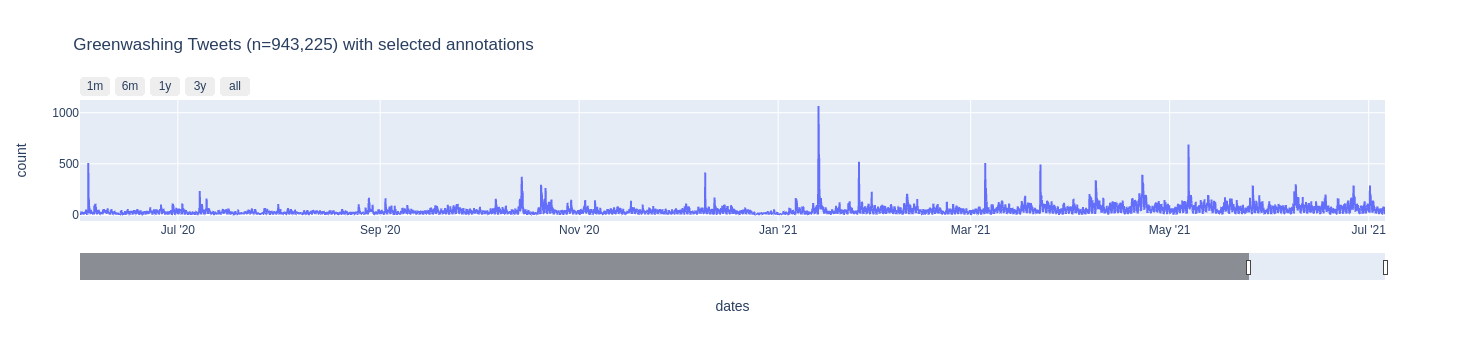

In [27]:
fig = px.line(
    df, 
    x='dates', 
    y='count',
    labels={'start': 'Time', 'day_count': 'Tweets per Day'},
    range_x=["2020-06-01", "2021-07-06"], # This is the default start zoom
    title='Greenwashing Tweets (n=943,225) with selected annotations' 
)
fig.update_xaxes(
    rangeslider_visible=True, # Enable slider
    tickformatstops = [
        dict(dtickrange=[None, 1000], value="%H:%M:%S.%L ms"),
        dict(dtickrange=[1000, 60000], value="%H:%M:%S s"),
        dict(dtickrange=[60000, 3600000], value="%H:%M m"),
        dict(dtickrange=[3600000, 86400000], value="%H:%M h"),
        dict(dtickrange=[86400000, 604800000], value="%e. %b"),
        dict(dtickrange=[604800000, "M1"], value="%e. %b"),
        dict(dtickrange=["M1", "M12"], value="%b '%y"),
        dict(dtickrange=["M12", None], value="%Y")
    ],
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            #dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(count=3, label="3y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)



fig.show()

In [ ]:
fig.add_annotation(x="2018-08-29T22:00", y=229,
            text="France's environmental activist<br>Hulot quits as ecology minister",
            showarrow=True,
            arrowhead=2)

fig.add_annotation(x="2019-12-02T09:00", y=591,
            text="COP25 Madrid",
            showarrow=True,
            arrowhead=2)

fig.add_annotation(x="2020-10-14T10:00", y=373,
            text="Apple Event: iPhone 12",
            showarrow=True,
            arrowhead=2)

fig.add_annotation(x="2020-12-09T15:00", y=416,
            text="Franco-Dutch call<br>to prevent greenwashing",
            showarrow=True,
            arrowhead=2)

fig.add_annotation(x="2021-01-13T07:00", y=1065,
            text="Greenwashing report tackling Blackrock",
            showarrow=True,
            arrowhead=2)

fig.add_annotation(x="2021-01-25T18:00", y=530,
            text="French strike<br>around a refinery",
            showarrow=True,
            arrowhead=2)

fig.add_annotation(x="2021-03-05T11:00", y=507,
            text="#WorldEnergyEfficiencyDay",
            showarrow=True,
            arrowhead=2)

fig.add_annotation(x="2021-03-22T09:00", y=494,
            text="EU report",
            showarrow=True,
            arrowhead=2)

#fig.add_annotation(x="2021-04-08T09:00", y=340,
#            text="Adbusting of Deutsche Bahn<br>; Founding of KlimaUnion",
#            showarrow=True,
#            arrowhead=2)

fig.add_annotation(x="2021-04-22T15:00", y=394,
            text="#EarthDay",
            showarrow=True,
            arrowhead=2)

fig.add_annotation(x="2021-05-06T19:00", y=688,
            text="Greenpeace report and Guardian article",
            showarrow=True,
            arrowhead=2)

The following code allows saving and implementing the interactive results on a website.

In [24]:
import plotly.io as pio
pio.write_html(fig, file='/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/plots/Greenwashing/greenwashing_freq_interactive.html', auto_open=False)

## Basic frequencies of the large data set

In [38]:
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
#import plotly.express as px
#import kaleido

## Frequencies per time

In [27]:
src = '/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Data/Greenwashing'
hashtags = ['greenwashing', 'greenwashing_correlated_hashtags'] # Perhaps add additional terms to offer comparisons. Like #pinkwashing etc.

Below is the basic code to get tweet frequency and allow complex matplotlib plotting per date. Mind the cutoff-date if there is older tweet information.

In [13]:
def get_tweet_frequency(src, filename, date_cutoff=pd.to_datetime('2011-06-15')):
    data = pd.read_csv(join(src, '{}.csv'.format(filename)), low_memory=False)
    print('{}: {} Tweets'.format(filename, len(data)))
    data['created_at'] = pd.to_datetime(data['created_at'])
    data['created_at_date'] = data['created_at'].dt.date
    data = data[data['created_at_date'] >= date_cutoff]
    
    frequency = data[['created_at_date', 'id']]\
        .groupby('created_at_date')\
        .agg('count')\
        .rename(columns={'id':'tweet_count'})
    
    return frequency

Below is the basic code to get tweet-frequency. Add another cell to add more than one data set. You will get two frequencies: all tweets and the most tweets during one day. 

In [24]:
frequency = get_tweet_frequency(src, 'greenwashing')
frequency.loc[frequency['tweet_count'].idxmax()]

greenwashing: 943225 Tweets


tweet_count    6831
Name: 2019-12-02, dtype: int64

In [14]:
frequency = get_tweet_frequency(src, 'greenwashing_correlated_hashtags')
frequency.loc[frequency['tweet_count'].idxmax()]

greenwashing_correlated_hashtags: 587867 Tweets


tweet_count    46207
Name: 2021-03-19, dtype: int64

### static and logarithmic

We created general graphs to understand the dynamics of Greenwashing activities on Twitter. After working with the main dataset (only "Greenwashing" tweets), we also broadened the search for the most correlated and relevant hashtags. This indicates a much larger dataset that discussed themes such as climate change and sustainability on a very general level.

greenwashing: 943225 Tweets
greenwashing_correlated_hashtags: 587867 Tweets


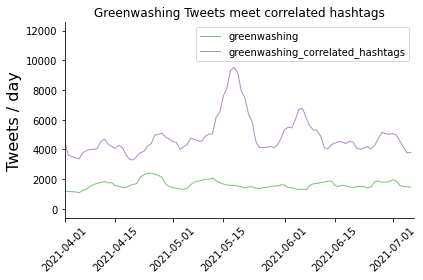

In [21]:
colors = ['#7fbf7b', '#af8dc3'] # add additional colours if there are more terms. '#d7191c', '#fdae61']

# Define the key code. Consider adjusting rolling from 1 (actual tweets per day) to 3 or 7 day averages  

fig, ax = plt.subplots()
for ht, color in zip(hashtags, colors):
    frequency = get_tweet_frequency(src, ht)
    frequency_avg = frequency['tweet_count'].rolling(7).mean().dropna() 
    ax.plot(frequency_avg.index, frequency_avg.values, color=color,
            label='{}'.format(ht), linewidth=1)
   
ax.set_yscale('linear') # Set linear or log 

ax.set_xlim(pd.to_datetime('2021-04-01'), pd.to_datetime('2021-07-07')) # Set dates on x axes
# Define the maximum on y axes (maximum tweets). Check the tweet frequency above (max. tweet per day)
#ax.set_ylim(ymax=1e6)
# Define ticks on x axes
#ax.set_xticks([pd.to_datetime(t) for t in ['2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01' ]]) #

ax.tick_params(axis='x', rotation=45) # Define rotation on x axes
ax.set_ylabel('Tweets / day', fontsize=16) # log (frequency) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend()

# Perhaps include arrow annotation
#ax.annotate("France's environmental activist Hulot\nquits as ecology minister", xy=(pd.to_datetime('2018-08-29'), 2100),  xycoords='data',
#            xytext=(-130, 20), textcoords='offset points',
#            arrowprops=dict(arrowstyle="->",
#                            connectionstyle="arc3,rad=-0.2"))


#ax.annotate("COP25 Madrid", xy=(pd.to_datetime('2019-12-02'), 6831),  xycoords='data',
#            xytext=(-80, -30), textcoords='offset points',
#            arrowprops=dict(arrowstyle="->",
#                            connectionstyle="arc3,rad=-0.2"))

#ax.annotate("Greenwashing report\ntackling Blackrock", xy=(pd.to_datetime('2021-01-13'), 6500),  xycoords='data',
#            xytext=(-80, 30), textcoords='offset points',
#            arrowprops=dict(arrowstyle="->",
#                            connectionstyle="arc3,rad=-0.2"))

ax.set_title("Greenwashing Tweets meet correlated hashtags")
#ax.text(pd.to_datetime('2014-06-01'), 1400, 'Averaged over 7 days.', fontsize=12, color='grey')
# Footnote

fig.tight_layout()

# Allow me to ask for a file name each time this code is run
# filename = input('Please give the file a name and avoid overriding\n') + '.png'
# plt.savefig('/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/plots/' + filename, dpi=300)
plt.savefig('/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/plots/Greenwashing/greenwashing_correlated_freq_lin.svg', format="svg")
plt.show()

The next graph looks at Greenwashing trends since 2014 and tests text annotations. In contrast to the interactive setup, this is output for non-digital types of publications.

greenwashing: 943225 Tweets


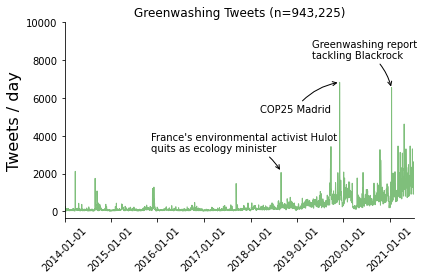

In [30]:
colors = ['#7fbf7b'] # add additional colours if there are more terms. '#d7191c', '#fdae61']

# Define the key code. Consider adjusting rolling from 1 (actual tweets per day) to 3 or 7 day averages  

fig, ax = plt.subplots()
for ht, color in zip(hashtags, colors):
    frequency = get_tweet_frequency(src, ht)
    frequency_avg = frequency['tweet_count'].rolling(1).mean().dropna() 
    ax.plot(frequency_avg.index, frequency_avg.values, color=color,
            label='{}'.format(ht), linewidth=1)
   
ax.set_yscale('linear') # Set linear or log 

ax.set_xlim(pd.to_datetime('2014-01-01'), pd.to_datetime('2021-07-07')) # Set dates on x axes
# Define the maximum on y axes (maximum tweets). Check the tweet frequency above (max. tweet per day)
ax.set_ylim(ymax=1e4)
# Define ticks on x axes
ax.set_xticks([pd.to_datetime(t) for t in ['2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01' ]]) #

ax.tick_params(axis='x', rotation=45) # Define rotation on x axes
ax.set_ylabel('Tweets / day', fontsize=16) # log (frequency) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.legend()

#Perhaps include arrow annotation
ax.annotate("France's environmental activist Hulot\nquits as ecology minister", xy=(pd.to_datetime('2018-08-29'), 2100),  xycoords='data',
            xytext=(-130, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2"))


ax.annotate("COP25 Madrid", xy=(pd.to_datetime('2019-12-02'), 6831),  xycoords='data',
            xytext=(-80, -30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2"))

ax.annotate("Greenwashing report\ntackling Blackrock", xy=(pd.to_datetime('2021-01-13'), 6500),  xycoords='data',
            xytext=(-80, 30), textcoords='offset points',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3,rad=-0.2"))

ax.set_title("Greenwashing Tweets (n=943,225)")
#ax.text(pd.to_datetime('2014-06-01'), 1400, 'Averaged over 7 days.', fontsize=12, color='grey')
# Footnote

fig.tight_layout()

# Allow me to ask for a file name each time this code is run
# filename = input('Please give the file a name and avoid overriding\n') + '.png'
# plt.savefig('/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/plots/' + filename, dpi=300)
plt.savefig('/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/plots/Greenwashing/greenwashing_freq_linear.svg', format="svg")
plt.show()

## Users

### Unique Users

This code calculates unique users and allows for comparisons, if required.

In [71]:
def get_N_authors(src, filename):
    data = pd.read_csv(join(src, '{}.csv'.format(filename)), low_memory=False)\
        .dropna(subset=['author_id'])
    data['author_id'] = data['author_id'].astype(int)
    N_authors = data['author_id'].unique()
    return len(N_authors)

In [72]:
N_authors = [get_N_authors(src, ht) for ht in hashtags]
N_authors = pd.DataFrame({'hashtag':['{}'.format(h) for h in hashtags],
                          'N_authors':N_authors})\
    .sort_values(by='N_authors')


In [73]:
#N_authors[0:1]
print(N_authors['N_authors'].values[0], 'users are tweeting about Greenwashing.')

395542 users are tweeting about Greenwashing.


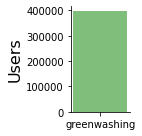

In [34]:
fig, ax = plt.subplots(figsize=(2, 2))
# Align color with the other graphs above (below it is based on automatic sorting)
ax.bar(N_authors['hashtag'], N_authors['N_authors'], color=['#7fbf7b']) # add additional colours if required, '#2c7bb6', '#d7191c'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Users', fontsize=16)
ax.tick_params(axis='x', labelsize=10, which='minor')
fig.tight_layout()
# Alternative: May I kindly know the name of the file you want to choose?
#filename = input('Please give the file a name and avoid overriding\n') + '.png'
# plt.savefig('/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/plots/' + filename, dpi=300)
plt.savefig('/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/plots/Greenwashing/greenwashing_users_freq.png', dpi=300)       

### Locations

In [78]:
print('{} users have provided a location'\
      .format(len(data.dropna(subset=['author.location']))))

681353 users have provided a location


In [80]:
data['author.location'].value_counts()[0:20]

Paris                  11241
France                 10512
London                  8788
Paris, France           8251
London, England         7118
Paris, Frankreich       4537
UK                      4228
Australia               3251
España                  3233
Berlin                  3210
Madrid                  3081
United Kingdom          3081
Washington, DC          3058
Frankreich              2873
Deutschland             2774
Berlin, Deutschland     2698
Global                  2652
Earth                   2471
USA                     2466
Canada                  2419
Name: author.location, dtype: int64

### Followers

In [34]:
def bracketize_followers(fls):
    if fls <= 100:
        return '0-100'
    elif fls <= 500:
        return '101-500'
    elif fls <= 1000:
        return '501-1000'
    elif fls <= 2000:
        return '1001-2000'
    elif fls <= 3000:
        return '2001-3000'
    elif fls <= 4000:
        return '3001-4000'
    elif fls <= 5000:
        return '4001-5000'
    elif fls <= 7500:
        return '5001-7500'
    elif fls <= 10000:
        return '7501-10000'
    else:
        return '>10000'

## Followers per user

In [55]:
data = pd.read_csv(join(src, ':DB_Bahn.csv'), encoding='utf-8', dtype='unicode', 
                   parse_dates=['created_at'])

In [45]:
follower_categories = ["0-100","101-500","501-1000","1001-2000","2001-3000",
                "3001-4000","4001-5000","5001-7500","7501-10000",">10000"]
data['followers'] = data['author.public_metrics.followers_count'].astype(float)\
    .apply(bracketize_followers)
data['followers'] = pd.Categorical(data['followers'],
                                categories=follower_categories, ordered=True)

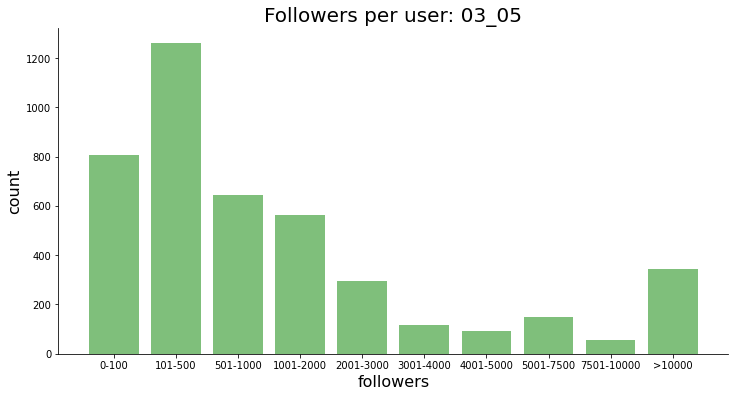

In [47]:
fig, ax = plt.subplots(figsize=(12,6))

ax.bar(data['followers'].value_counts().sort_index().index, 
       data['followers'].value_counts().sort_index().values, color='#7fbf7b')
ax.set_ylabel('count', fontsize=16)
ax.set_xlabel('followers', fontsize=16)
ax.set_title('Followers per user: 03_05', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/plots/Greenwashing/greenwashing_follower_03_05.svg', format='svg')

## Get ratios

This code gets us closer to comparing engagement statistics through events. We suggest developing a particular kind of ratio that reflects greenwashing-specific engagement (a green_interactor_ratio) that puts into perspective the users engaging with an account trough greenwashing accusations.

In [49]:
# Standard follower/following ratio
data = pd.read_csv(join(src, ':DB_Bahn.csv'), encoding='utf-8', dtype='unicode', 
                   parse_dates=['created_at'])
relationship_ratio = (data['author.public_metrics.followers_count'].astype(float)/data['author.public_metrics.following_count'].astype(float))
                      # if not reverse_relationship
                        #else float('author.public_metrics.followers_count')/float(data['author.public_metrics.following_count']))
data['relationship_ratio'] = relationship_ratio        

In [65]:
def get_tweet_frequency(src, filename, date_cutoff=pd.to_datetime('2011-06-15')):
    data = pd.read_csv(join(src, '{}.csv'.format(filename)), low_memory=False)
    print('{}: {} Tweets'.format(filename, len(data)))
    data['created_at'] = pd.to_datetime(data['created_at'])
    data['created_at_date'] = data['created_at'].dt.date
    data = data[data['created_at_date'] >= date_cutoff]
    
    frequency = data[['created_at_date', 'id']]\
        .groupby('created_at_date')\
        .agg('count')\
        .rename(columns={'id':'tweet_count'})
    
    return frequency

src = '/media/s/Linux_storage/Analyse_Verkehrswende_Transformation/Data/Greenwashing'
#hashtags = (':DB_Bahn.csv')
frequency = get_tweet_frequency(src, 'shell.csv')

shell.csv: 1238 Tweets


In [66]:
## Standard Interactor ratio. (Works only for mentions of accounts queries.) Number of users who mention an account/followers
interactor_ratio = 1130209/128000

interactor_ratio

## Green Interactor ratio
green_interactor_ratio = 1238/551200

green_interactor_ratio

0.002246008708272859